# Calculating Lagrangian trajectories from ocean-only (uncoupled)  and ocean-wave (coupled) model simulations for the MedSea

## 1. General Settings

### 1.1 Load modules and check versions

In [1]:
from glob import glob
from datetime import timedelta, datetime
import math

from parcels import (FieldSet, ParticleSet,
                     JITParticle, ScipyParticle,
                     AdvectionRK4,
                     Variable, Field, VectorField)
import xarray as xr
import numpy as np

%matplotlib inline

In [2]:
# modified after: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
## make sure to use Parcels version 2.4.0 or later for zarr output

import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]            
        yield name
imports = list(set(get_imports()))
# get the version of the root package from only the name of the package
# via cross-checking the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
for r in requirements:
    print("{}=={}".format(*r))

xarray==2022.12.0
parcels==2.4.0
numpy==1.24.1



### 1.2 Define general custom functions


In [3]:
# DEFINE ALTERNATIVE TO USE NP.ARANGE
#
# from https://stackoverflow.com/questions/50299172/python-range-or-numpy-arange-with-end-limit-include
# (code posted by Markus Dutschke on Aug 2nd 2019, last accessed on Dec 6th 2023)
#
# WHY using it? 
# In principal, values are generated within the half-open interval [start, stop)
# (in other words, the interval including start but excluding stop). 
# Yet, unfortunately, when using a non-integer step (such as 0.1), 
# the results of np.arange are often not consistent. 
# Specifically, they sometimes do include the stop value.
# It is better to use the following function based on numpy.linspace for these cases

def cust_range(*args, rtol=1e-05, atol=1e-08, include=[True, False]):
    """
    Combines numpy.arange and numpy.isclose to mimic
    open, half-open and closed intervals.
    Avoids also floating point rounding errors as with
    >>> numpy.arange(1, 1.3, 0.1)
    array([1. , 1.1, 1.2, 1.3])

    args: [start, ]stop, [step, ]
        as in numpy.arange
    rtol, atol: floats
        floating point tolerance as in numpy.isclose
    include: boolean list-like, length 2
        if start and end point are included
    """
    # process arguments
    if len(args) == 1:
        start = 0
        stop = args[0]
        step = 1
    elif len(args) == 2:
        start, stop = args
        step = 1
    else:
        assert len(args) == 3
        start, stop, step = tuple(args)

    # determine number of segments
    n = (stop-start)/step + 1

    # do rounding for n
    if np.isclose(n, np.round(n), rtol=rtol, atol=atol):
        n = np.round(n)

    # correct for start/end is exluded
    if not include[0]:
        n -= 1
        start += step
    if not include[1]:
        n -= 1
        stop -= step

    return np.linspace(start, stop, int(n))

def crange(*args, **kwargs):
    return cust_range(*args, **kwargs, include=[True, True])

def orange(*args, **kwargs):
    return cust_range(*args, **kwargs, include=[True, False])

print("crange(1, 1.3, 0.1) >>>", crange(1, 1.3, 0.1))
print("orange(1, 1.3, 0.1) >>>", orange(1, 1.3, 0.1))
print("crange(0.0, 0.6, 0.2) >>>", crange(0.0, 0.6, 0.2))
print("orange(0.0, 0.6, 0.2) >>>", orange(0.0, 0.6, 0.2))

crange(1, 1.3, 0.1) >>> [1.  1.1 1.2 1.3]
orange(1, 1.3, 0.1) >>> [1.  1.1 1.2]
crange(0.0, 0.6, 0.2) >>> [0.  0.2 0.4 0.6]
orange(0.0, 0.6, 0.2) >>> [0.  0.2 0.4]


## 2. Custom settings Parcels
!!! IMPORTANT: need to be checked/adjusted before every execution !!! Particularly check the parts highlighted within lines of #### !!!

### 2.1 Define input paths


In [4]:
############################

# set key to 'uncoupled', 'uncoupled_sd', 'coupled_nosd', or 'coupled_sd'
key_input = 'coupled_sd'

# define whether ocean velocity is sampled (key_sample_velocity = True)
key_sample_velocity = True

############################

datapath = '/Users/siren/Data/IMMERSE/'
# path were original velocity putput is stored

gridpath = (datapath + 'domain/fgrid.nc')
# path were model grid info is stored

if (key_input == 'uncoupled') or (key_input == 'uncoupled_sd'):
    filepaths_u = sorted(glob(datapath + 'surface_TKE_UNC/MED24_OBC_1d*_grid_U.nc'))
    filepaths_v = sorted(glob(datapath + 'surface_TKE_UNC/MED24_OBC_1d*_grid_V.nc'))
    if key_input == 'uncoupled':
        key_stokes = False
        print('calculate trajectories for uncoupled simulation without additional consideration of Stokes drift')
    elif key_input == 'uncoupled_sd':
        key_stokes = True
        filepaths_usd = sorted(glob(datapath + 'surface_TKE_CO/MED24_OBC_1d*_grid_U.nc'))
        filepaths_vsd = sorted(glob(datapath + 'surface_TKE_CO/MED24_OBC_1d*_grid_V.nc'))
        print('calculate trajectories for uncoupled simulation without additional consideration of Stokes drift')

elif (key_input == 'coupled_nosd') or (key_input == 'coupled_sd'):
    filepaths_u = sorted(glob(datapath + 'surface_TKE_CO/MED24_OBC_1d*_grid_U.nc'))
    filepaths_v = sorted(glob(datapath + 'surface_TKE_CO/MED24_OBC_1d*_grid_V.nc'))
    if key_input == 'coupled_nosd':
        key_stokes = False
        print('calculate trajectories for coupled simulation without explicit consideration of Stokes drift')
    elif key_input == 'coupled_sd':
        key_stokes = True
        filepaths_usd = filepaths_u
        filepaths_vsd = filepaths_v
        print('calculate trajectories for coupled simulation with explicit consideration of Stokes drift')

else:
    print('no (valid) key_input defined')

calculate trajectories for coupled simulation with explicit consideration of Stokes drift


###  2.2 Define Particle release grid

In [5]:
############################

# release_name can be 
# - "GulfOfLion" (particles released every 5 days over one year), or
# - "Test" (particles released over one time step only)

release_name = 'GulfOfLion'

############################

tstart_release = 0 # first release time in time steps of input data set after start of input data set (here: daily)
deltat_release = 5 # release from the same set of locations every deltat_release time steps

times_convert = 86400 # time step of input data in seconds (here: daily)

if release_name == "Test":
    tend_release = 10 
else:
    tend_release = 365 
# in time steps of input data set after start of input data set

if (release_name == 'GulfOfLion') or (release_name == 'Test'):
    lonmin = 3
    lonmax = 5.6
    latmin = 42.1
    latmax = 43.5
    step = 0.05 #(appr. every grid cell)

if release_name == 'SubReg14':
    lonmin = 30.3
    lonmax = 32.3
    latmin = 35
    latmax = 37
    step = 0.05 #(appr. every 5th grid cell)

if release_name == 'SubReg7':
    lonmin = 10
    lonmax = 12
    latmin = 33
    latmax = 35.3
    step = 0.05 #(appr. every 5th grid cell)

if release_name == 'MedSeaMid':
    lonmin = -0.6
    lonmax = 22
    latmin = 31
    latmax = 46
    step = 0.2 #(appr. every 5th grid cell)

if release_name == 'MedSeaEast':
    lonmin = 22.2
    lonmax = 36.2
    latmin = 31
    latmax = 46
    step = 0.2 #(appr. every 5th grid cell)
    
if release_name == 'MedSeaWest':
    lonmin = -18.0
    lonmax = -0.8
    latmin = 31
    latmax = 46
    step = 0.2 #(appr. every 5th grid cell)
    
lons, lats = np.meshgrid(crange(lonmin, lonmax, step),
                         crange(latmin, latmax, step))
n_releasepos = lons.shape[0]*lons.shape[1]
n_particles = n_releasepos * ((tend_release-tstart_release)/deltat_release)
print("maximum number of release positions (including land):", n_releasepos)
print("maximum number of particles (including land):", int(n_particles))


maximum number of release positions (including land): 1537
maximum number of particles (including land): 112201


### 2.3 Define Lagrangian trajectory integration parameters


In [6]:
tint = 30 # in days
deltat = 25 # in minutes
# How to chose deltat (Schmidt et al., 2021):
### The time step dt should be small enough that particles do not skip grid cells
### and thereby miss characteristic oceanographic features. 
### Due to trade-off between accuracy of time stepping and computation time, the integration
### time step dt was chosen such that particles stay in one model grid cell for at least 2dt
### Therefore, a time step dt can be calculated following dt<dsmin/(vmax⋅2)
### where dsmin is the smallest edge of all grid cells in the domain and
### vmax is the largest horizontal velocity.
### assume vmax = 1m/s, dsmin = 1/24 = 3000 m : dt < (3000 / 2)s = 1500 s = 25 min 
### (at 45N - northern boundary MedSea - 1deg lon is appr. 79km -> 1/24 deg = 3300m;
### 1 deg lat is 111km)

pclass = JITParticle # can be JITParticle or ScipyParticle

### 2.4 Define Lagrangian trajectory output

In [7]:
############################

outdt = 1 #in days

############################

procpath = '/Users/siren/IMMERSE_waves/develop-mac/data/Trajectories-revisedNEMO/' + release_name +'/'
! mkdir -p $procpath #creates output folder if it does not exist yet

if key_input == 'uncoupled':
    outpath = (procpath + 'Parcels_CalcTraj_Data-uncoupled_Release-' + release_name)
if key_input == 'uncoupled_sd':
    outpath = (procpath + 'Parcels_CalcTraj_Data-uncoupled-sd_Release-' + release_name)
elif key_input == 'coupled_nosd':
    outpath = (procpath + 'Parcels_CalcTraj_Data-coupled-nosd_Release-' + release_name)
elif key_input == 'coupled_sd':
    outpath = (procpath + 'Parcels_CalcTraj_Data-coupled-sd_Release-' + release_name)

## 3. Execution of parcels simulation

### 3.1 Create custom Parcels functions

In [8]:
def create_fieldset(keystokes=False):
    
    filenames = {'U': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_u},
                 'V': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_v}}
    variables = {'U': 'vozocrtx',
                 'V': 'vomecrty'}
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'},
                  'V': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}}
    fieldset = FieldSet.from_nemo(filenames, variables, dimensions,
                                  mesh='spherical',
                                  allow_time_extrapolation=False,
                                  time_periodic=False)
        
    if keystokes == True:
        filenames_sd = {'U': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_usd},
                        'V': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_vsd}}
        variables_sd = {'U': 'usd',
                        'V': 'vsd'}
        fieldset_sd = FieldSet.from_nemo(filenames_sd, variables_sd, dimensions,
                                         mesh='spherical',
                                         allow_time_extrapolation=False,
                                         time_periodic=False)
        fieldset_sum = FieldSet(U=fieldset.U+fieldset_sd.U,
                                V=fieldset.V+fieldset_sd.V)
        fieldset_use = fieldset_sum
    elif keystokes == False:
        fieldset_use = fieldset
        
    return fieldset_use



Kernels partially adopted and modified from https://github.com/OceanParcels/Parcelsv2.0PaperNorthSeaScripts


In [9]:
class BeachParticle(pclass):
    # beached : 0 sea, 1 beached, 2 after non-beach dyn
    beached = Variable('beached', dtype=np.int64, initial=2)

In [10]:
class BeachCurrentParticle(pclass):
    # beached : 0 sea, 1 beached, 2 after non-beach dyn
    beached = Variable('beached', dtype=np.int64, initial=0)
    U = Variable('U', dtype=np.float32, initial=0)
    V = Variable('V', dtype=np.float32, initial=0)

In [11]:
def AdvectionRK4(particle, fieldset, time):
    if particle.beached == 0:
        (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
        lon1, lat1 = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)

        (u2, v2) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat1, lon1]
        lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)

        (u3, v3) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat2, lon2]
        lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)

        (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3]
        particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle.beached = 2

In [12]:
def SampleUV(particle, fieldset, time):
    # attention: samples particle velocity in deg/s and needs to be converted to m/s
    # also note that fieldset is sampled at time+particle.dt, as first advection id performed and positions are updated,
    # then fieldset is sampled at new location and time+dt, the time is updated
    ## this procedure will probably not be necessary with future parcel releases
    particle.U, particle.V = fieldset.UV[particle.time+particle.dt, particle.depth, particle.lat, particle.lon]

In [13]:
def BeachTesting(particle, fieldset, time):
    if particle.beached == 2:
        (u, v) = fieldset.UV[particle.time+particle.dt, particle.depth, particle.lat, particle.lon]
        # if velocity threshold ist set to 1e-8 (suggestion Christian) artificial beaching occurs -> do NOT do that
        if math.fabs(u) < 1e-14 and math.fabs(v) < 1e-14:
            particle.beached = 1
            print("Particle [%d] beached !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time+particle.dt))
        else:
            particle.beached = 0

In [14]:
def BeachTesting_initial(particle, fieldset, time):
    if particle.beached == 2:
        (u, v) = fieldset.UV[particle.time, particle.depth, particle.lat, particle.lon]
        # if velocity threshold ist set to 1e-8 (suggestion Christian) artificial beaching occurs -> do NOT do that
        if math.fabs(u) < 1e-14 and math.fabs(v) < 1e-14:
            particle.beached = 1
            print("Particle [%d] beached !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
        else:
            particle.beached = 0

In [15]:
def DeleteParticle(particle, fieldset, time):
    if particle.beached == 1:
        particle.delete()
        print("Particle [%d] deleted !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))

In [16]:
def PlotParticleSet(pset,fieldset):
    plotstep=4
    pset.show(field=fieldset.U,
              domain={'N':(latmax+plotstep/2),'S':(latmin-plotstep),
                      'E': (lonmax+plotstep), 'W':(lonmin-plotstep)})

In [17]:
def PlotParticleSet(pset,fieldset):
    plotstep=2 #for larger values velocity field will be sampled out of bounds with our chosen release regions
    pset.show(field=fieldset.U,
              domain={'N':(latmax+plotstep),'S':(latmin-plotstep),
                      'E': (lonmax+plotstep), 'W':(lonmin-plotstep)})

### 3.2 Determine exact particle release positions (mask land positions)

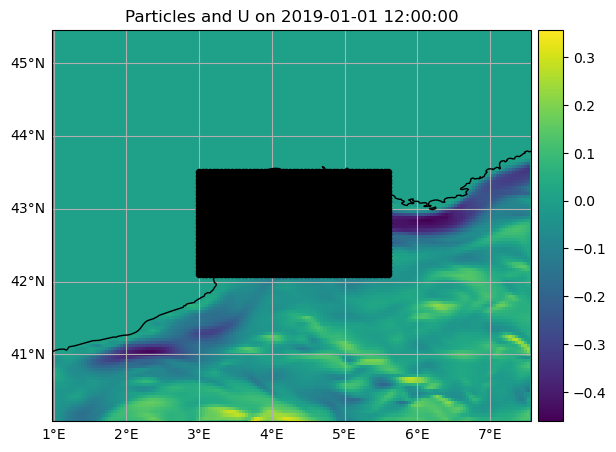

maximum number of release positions (including land): 1537



INFO: Compiled ArrayBeachParticleBeachTesting_initialDeleteParticle ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib87b52b6a1cd2dfebf0e40dc92501511c_0.so


Particle [0] beached !! (3 42.1 0 0)
Particle [1] beached !! (3.05 42.1 0 0)
Particle [2] beached !! (3.1 42.1 0 0)
Particle [3] beached !! (3.15 42.1 0 0)
Particle [53] beached !! (3 42.15 0 0)
Particle [54] beached !! (3.05 42.15 0 0)
Particle [55] beached !! (3.1 42.15 0 0)
Particle [106] beached !! (3 42.2 0 0)
Particle [107] beached !! (3.05 42.2 0 0)
Particle [108] beached !! (3.1 42.2 0 0)
Particle [159] beached !! (3 42.25 0 0)
Particle [160] beached !! (3.05 42.25 0 0)
Particle [161] beached !! (3.1 42.25 0 0)
Particle [212] beached !! (3 42.3 0 0)
Particle [213] beached !! (3.05 42.3 0 0)
Particle [214] beached !! (3.1 42.3 0 0)
Particle [215] beached !! (3.15 42.3 0 0)
Particle [216] beached !! (3.2 42.3 0 0)
Particle [217] beached !! (3.25 42.3 0 0)
Particle [218] beached !! (3.3 42.3 0 0)
Particle [265] beached !! (3 42.35 0 0)
Particle [266] beached !! (3.05 42.35 0 0)
Particle [267] beached !! (3.1 42.35 0 0)
Particle [268] beached !! (3.15 42.35 0 0)
Particle [318] beac

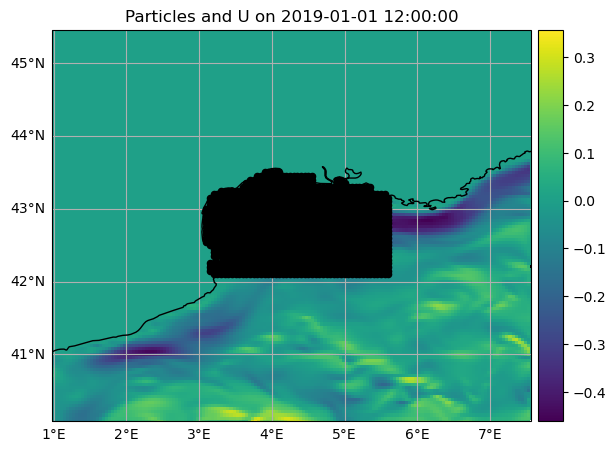

actual number of release positions (excluding land): 1291
actual number of particles: 94243.0


In [18]:
# release particles on predefined uniform grid, including land grid points
fieldset_init = create_fieldset(keystokes=False)
pset_init = ParticleSet(fieldset=fieldset_init,
                        pclass=BeachParticle,
                        lon=lons, lat=lats, time=0)
pset_init.populate_indices()
PlotParticleSet(pset_init,fieldset_init)
print('maximum number of release positions (including land):',pset_init.lon.size)
print()
lons_prelim = pset_init.lon
lats_prelim = pset_init.lat

# perform a "fake" integration to determine and delete particles released on land
## by making use of beach-testing and deleting kernels
## (without advection kernel)
kernels_init = pset_init.Kernel(BeachTesting_initial) + pset_init.Kernel(DeleteParticle)
pset_init.execute(kernels_init, dt=0)
PlotParticleSet(pset_init,fieldset_init)

# retrieve lon and lats from all ocean release positions
print("actual number of release positions (excluding land):", pset_init.lon.size)
print("actual number of particles:",
      pset_init.lon.size * ((tend_release-tstart_release)/deltat_release))
lons_use = pset_init.lon
lats_use = pset_init.lat

### 3.3 Perform trajectory integration and save trajectories in .zarr format

In [19]:
%%time
for times in range(tstart_release, tend_release, deltat_release):
    
    if (key_sample_velocity == True):
        pclass_main = BeachCurrentParticle
        outpath_ending = "m_Sample-UV.zarr"
    else:
        pclass_main=BeachParticle
        outpath_ending = "m.zarr"
  
    ## create new clean particle set (including new clean fieldset)
    ### ensure that for each release date the particle numbering starts again from 0
    fieldset_main = create_fieldset(keystokes=key_stokes)
    BeachCurrentParticle.setLastID(0)
    BeachParticle.setLastID(0)
    pset_main = ParticleSet(fieldset=fieldset_main,
                            pclass=pclass_main,
                            lon=lons_use, lat=lats_use,
                            time=times*times_convert)   
    pset_main.populate_indices()
    
    ## define output
    ### ensure depth is not stored in trajectory output (depth not necessary for 2D calculations)
    pset_main.set_variable_write_status("depth", False) 
    outpath_final = (outpath + "-t" + str(times) 
                     + "_Integrate-fw-d" + str(tint) + "-dt" + str(deltat) 
                     + outpath_ending)
    outfile_final = pset_main.ParticleFile(outpath_final, 
                                           outputdt=timedelta(days=outdt))
  
    ## advect particle
    ## do not delete potentially beached particles, but keep them for statistics
    if (key_sample_velocity == True):
        kernels_main = (pset_main.Kernel(AdvectionRK4) + pset_main.Kernel(BeachTesting) 
                        + pset_main.Kernel(SampleUV))
    else:
        kernels_main = (pset_main.Kernel(AdvectionRK4) + pset_main.Kernel(BeachTesting))
    pset_main.execute(kernels_main,
                      runtime=timedelta(days=tint),
                      dt=timedelta(minutes=deltat),
                      output_file=outfile_final)
    
    pset_main.set_variable_write_status("depth", True) # somehow needed, otherwise next pset can not be build


INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib22a0a90acf9e71a78202c61e1f81af46_0.so
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarn

Particle [149] beached !! (3.10417 42.25 0 950400)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

Particle [149] beached !! (3.10417 42.25 0 1.2096e+06)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

Particle [149] beached !! (3.10417 42.25 0 2.4192e+06)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

Particle [149] beached !! (3.10417 42.25 0 2.9376e+06)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

Particle [149] beached !! (3.10417 42.25 0 7.4304e+06)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib4eeb0f06a7bcae18d4124e97643fbfa3_0.so
<__array_function__ internals>:200: RuntimeWarn

Particle [149] beached !! (3.10417 42.25 0 7.4304e+06)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

Particle [149] beached !! (3.10417 42.25 0 7.4304e+06)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

Particle [443] beached !! (3.22908 42.0832 0 1.4688e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Particle [1150] beached !! (3.27083 43.25 0 1.52064e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Particle [1151] beached !! (3.27083 43.25 0 1.52928e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/libe7cd885abc5a23211a7ab8f6f306de42_0.so
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Particle [1097] beached !! (5.39579 43.1667 0 1.3392e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

Particle [1150] beached !! (3.27083 43.25 0 1.53792e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Particle [1151] beached !! (3.27083 43.25 0 1.57248e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib49472ca064de664d17ee450bdb677464_0.so
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarn

Particle [1150] beached !! (3.27083 43.25 0 1.57248e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

Particle [149] beached !! (3.10417 42.25 0 2.22912e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib3c1b0f4c9c1adce3a617cdf8f6c1f869_0.so
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarn

Particle [874] beached !! (1.6039 41.1668 0 2.19456e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Particle [149] beached !! (3.10417 42.25 0 2.2464e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/li

Particle [754] beached !! (2.77061 41.6251 0 2.29824e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

Particle [1286] beached !! (3.85417 43.5 0 2.47968e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/libb33faa0aad516dd5a8abd524d1a2d5de_0.so
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarn

Particle [1286] beached !! (3.85417 43.5 0 2.61792e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/liba80a4433a85a35b76a1037d0bd7ef98d_0.so
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarn

Particle [1286] beached !! (3.85417 43.5 0 2.61792e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib4cc3b908935247c18349f7fb1457980d_0.so
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarn

Particle [1286] beached !! (3.85417 43.5 0 2.61792e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

Particle [149] beached !! (3.10417 42.25 0 2.91168e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib0eb96ccf000e25367a9c816e52ff4350_0.so
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarn

Particle [149] beached !! (3.10417 42.25 0 2.94624e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Particle [150] beached !! (3.10417 42.25 0 2.97216e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/libeffccff0923e991931980db0c79fa4d1_0.so
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarn

Particle [149] beached !! (3.10417 42.25 0 2.97216e+07)
Particle [150] beached !! (3.10417 42.25 0 2.97216e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib214efa2dd26c56b91314113dd3d18caf_0.so
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarn

Particle [149] beached !! (3.10417 42.25 0 2.97216e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Particle [150] beached !! (3.10417 42.25 0 2.9808e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/li

Particle [149] beached !! (3.10417 42.25 0 2.9808e+07)
Particle [150] beached !! (3.10417 42.25 0 2.9808e+07)
Particle [151] beached !! (3.10417 42.25 0 2.9808e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

Particle [110] beached !! (2.89658 39.1254 0 3.11904e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO: Compiled ArrayBeachCurrentParticleAdvectionRK4BeachTestingSampleUV ==> /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/lib0e712e9d74d53945489e552d2a7f6300_0.so
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarn

Particle [1049] beached !! (5.395 43.1668 0 3.03264e+07)


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

Particle [1286] beached !! (3.85417 43.5 0 3.35232e+07)


  0%|          | 0/2592000.0 [00:00<?, ?it/s]<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
 97%|█████████▋| 2505600.0/2592000.0 [00:00<00:00, 12699629.38it/s]<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
100%|██████████| 2592000.0/2592000.0 [00:00<00:00, 6236478.98it/s] 

CPU times: user 1h 11min, sys: 4min 26s, total: 1h 15min 26s
Wall time: 1h 18min 32s


In [20]:
# Plotting of final positions 
## in this simple form only works for uncoupled simulation
## as Parcels plotting routine can not deal with summed fieldsets
PlotParticleSet(pset_main,fieldset_main)

TypeError: getattr(): attribute name must be string